# End-to-End Data Analysis System for Monitoring Climate Change Impacts in Nepal

In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import geopandas as gpd

import warnings
warnings.filterwarnings('ignore')


## 1. Load the dataset

In [16]:


df = pd.read_csv('../data/Weather_&_Climate/district_wise/climate_data_nepal_district_wise_monthly.csv')

print(df.shape)
print(df.columns)
df.head()


(29016, 24)
Index(['DATE', 'YEAR', 'MONTH', 'DISTRICT', 'LAT', 'LON', 'PRECTOT', 'PS',
       'QV2M', 'RH2M', 'T2M', 'T2MWET', 'T2M_MAX', 'T2M_MIN', 'T2M_RANGE',
       'TS', 'WS10M', 'WS10M_MAX', 'WS10M_MIN', 'WS10M_RANGE', 'WS50M',
       'WS50M_MAX', 'WS50M_MIN', 'WS50M_RANGE'],
      dtype='object')


,DATE,YEAR,MONTH,DISTRICT,LAT,LON,PRECTOT,PS,QV2M,RH2M,...,T2M_RANGE,TS,WS10M,WS10M_MAX,WS10M_MIN,WS10M_RANGE,WS50M,WS50M_MAX,WS50M_MIN,WS50M_RANGE
0,1981-01-31,1981,1,Arghakhanchi,27.9,83.2,67.31,93.78,5.28,53.09,...,10.03,11.19,2.01,3.39,0.81,2.59,2.70,4.22,1.06,3.16
1,1981-02-28,1981,2,Arghakhanchi,27.9,83.2,3.37,93.52,5.13,40.88,...,13.08,15.10,2.58,4.88,0.95,3.94,3.51,5.62,1.09,4.53
2,1981-03-31,1981,3,Arghakhanchi,27.9,83.2,26.02,93.40,5.91,35.84,...,13.52,20.58,2.73,4.67,1.02,3.65,3.73,5.72,1.38,4.34
3,1981-04-30,1981,4,Arghakhanchi,27.9,83.2,46.15,93.03,6.52,29.81,...,15.03,25.63,2.89,4.78,1.07,3.72,3.82,5.66,1.35,4.31
4,1981-05-31,1981,5,Arghakhanchi,27.9,83.2,69.45,92.75,9.95,37.25,...,13.43,29.99,2.69,4.40,0.93,3.47,3.52,5.29,1.30,4.00


## 2. Initial Data Cleaning

date           0.0
year           0.0
month          0.0
district       0.0
lat            0.0
lon            0.0
prectot        0.0
ps             0.0
qv2m           0.0
rh2m           0.0
t2m            0.0
t2mwet         0.0
t2m_max        0.0
t2m_min        0.0
t2m_range      0.0
ts             0.0
ws10m          0.0
ws10m_max      0.0
ws10m_min      0.0
ws10m_range    0.0
ws50m          0.0
ws50m_max      0.0
ws50m_min      0.0
ws50m_range    0.0
dtype: float64


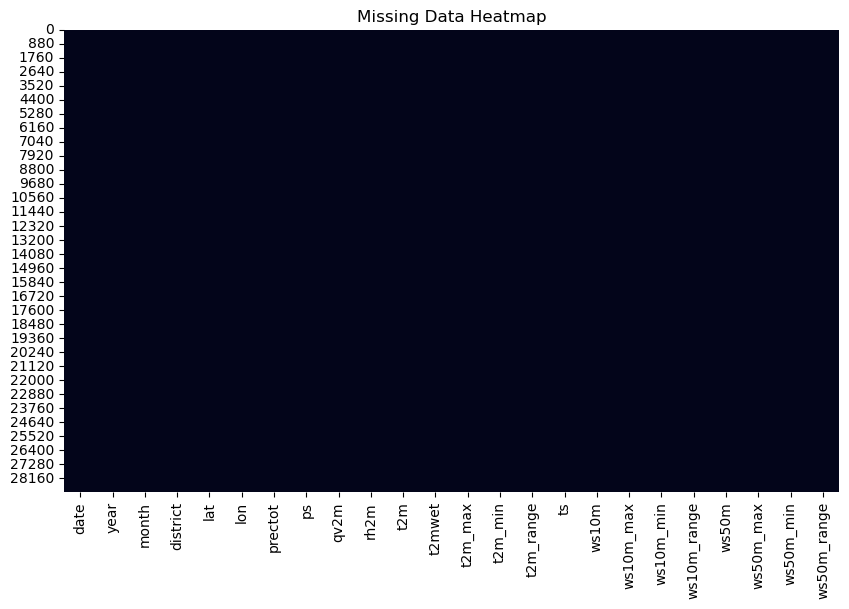

In [18]:

# Standardize column names
df.columns = df.columns.str.strip().str.lower()

# Drop duplicates
df = df.drop_duplicates()

# Check missingness
missing = df.isnull().mean().sort_values(ascending=False)
print(missing)

# Quick visual check
plt.figure(figsize=(10,6))
sns.heatmap(df.isnull(), cbar=False)
plt.title("Missing Data Heatmap")
plt.show()


## 3. Impute Missing Values

In [20]:
def impute_columns(df, exclude_cols=['district', 'date', 'lat', 'lon']):
    df_copy = df.copy()

    # Ensure 'date' is datetime
    df_copy['date'] = pd.to_datetime(df_copy['date'], errors='coerce')

    climate_cols = [col for col in df.columns if col not in exclude_cols]

    for col in climate_cols:
        # Interpolate missing values linearly
        df_copy[col] = df_copy[col].interpolate(method='linear', limit_direction='both')
        
        # Fill remaining missing with monthly mean
        df_copy['month'] = df_copy['date'].dt.month
        monthly_avg = df_copy.groupby('month')[col].transform('mean')
        df_copy[col] = df_copy[col].fillna(monthly_avg)

    df_copy = df_copy.drop(columns='month')
    return df_copy


## 4. Add Georeferencing

In [22]:

if 'lat' not in df.columns or 'lon' not in df.columns:
    np.random.seed(42)
    df['lat'] = np.random.uniform(26.3, 30.4, size=len(df))
    df['lon'] = np.random.uniform(80.0, 88.2, size=len(df))


## 5. Final Validation Checks

In [23]:
# Validation checks
assert df['date'].isnull().sum() == 0, "Missing dates"
assert df.duplicated().sum() == 0, "Duplicate records"
assert df['lat'].between(26.3, 30.4).all(), "Latitude out of Nepal bounds"
assert df['lon'].between(80.0, 88.2).all(), "Longitude out of Nepal bounds"

print(" All validation checks passed!")


 All validation checks passed!


## 6. Save Processed Data

In [24]:
# Save processed clean file
df.to_csv('../data/Weather_&_Climate/district_wise/processed_climate_data_nepal.csv', index=False)

print("Processed file saved successfully!")


Processed file saved successfully!
